# TISSUE CORRECTION
### Created by: Samantha A Leech, Last updated: April 19, 2024 

**Purpose:** performs relaxation and tissue correction for proton magnetic resonance spectroscopy data <br>
**Required:** an excel sheet that contains...<br>
-segmented tissue volume fractions (extracted using FSL or SPM12, which can be implemented with the Gannet CoRegStandAlone function in MatLab)<br>-raw signal data for NAA, tCr, tCho, Glu, Glx, Myo (for example, output quantification from LCModel)
        
**Step 1**<br>Scroll down to the "Your Inputs" and fill in the required information

**Step 2**<br>Press Run

**Step 3**<br>Your tissue corrected outputs will be saved in the Excel sheet your set as your data output file path as 6 separate sheets called "NAA_TissueCorr", "Cr_TissueCorr", "Cho_TissueCorr", "Glu_TissueCorr", "Glx_TissueCorr", and "Myo_TissueCorr". Within each sheet there will be molal (mmol/kg) and molar (mmol/L) output with suffixes "_MolalAlpha" and "_MolarAlpha" for concentrations outputs with the recommended alpha correction (that accounts for differening concentrations of metabolites in GM and WM), noramlized to an 100% GM voxel. Suffixes "_MolalNorm" and "_MolarNorm" are alpha corrected but normalized to a 50% GM, 50% WM voxel. Suffixes "_MolalCSF" and "_MolarCSF" are CSF corrected as per Gasparovic et al (2018).

**Step 4**<br>Scroll down to the bottom of the sheet and see how your data performed with the recommended "Alpha correction" as per Leech et al (2024) compared to the conventional "CSF correction" by Gasparovic et al (2018) - the flatter the regression line, better! (Note: these lines will be the same for choline as alpha = 1).

**Step 5**<br>If desired, play around with the alpha values. For example, if you have anteriorly located voxels, you may choose to use the anterior alpha values whereas if you have a mixture of voxels located throughout the brain, it might be best to keep the default values.


### Your Inputs

In [5]:
#Data INPUT file path (e.g.'/File/path/to/TissCorr_Test.xlsx'):
my_INPUT_filepath = '/File/path/to/TissCorr_Test.xlsx'

#Data OUTPUT file path (e.g.'/File/path/to/TissCorr_Test.xlsx'):
my_OUTPUT_filepath = '/File/path/to/TissCorr_Test.xlsx'

#GM volume fraction column name (e.g.'fGM_vol'):
GM_fraction_column_name = 'fGM_vol'

#WM volume fraction column name (e.g. 'f_WM_vol'):
WM_fraction_column_name = 'fWM_vol'

#CSF volume fraction column name (e.g. 'f_CSF_vol'):
CSF_fraction_column_name = 'fCSF_vol'

#tNAA data column name (e.g. ' NAA+NAAG'):
tNAA_data_column_name = 'tNAA'

#tCr data column name (e.g. ' Cr+PCr'):
tCr_data_column_name = 'tCr'

#tCho data column name (e.g. ' Cho+GPC+PCh'):
tCho_data_column_name = 'tCho'

#Myo data column name (e.g. ' mI'):
Myo_data_column_name = 'Myo'

#Glu data column name (e.g. ' Glu'):
Glu_data_column_name = 'Glu'

#Glx data column name (e.g. ' Glu+Gln'):
Glx_data_column_name = 'Glx'

#TE [in seconds] (e.g. 0.035):
TE_sec = 0.030

#TR [in seconds] (e.g. 3):
TR_sec = 1.8

### Process Inputs

In [6]:
import math
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
import statsmodels.api as sm
from ipywidgets import widgets
from IPython.display import display


# Default values from the script
default_mdata = my_INPUT_filepath
default_ExcelSheet = my_OUTPUT_filepath
default_f_GM_vol = GM_fraction_column_name
default_f_WM_vol = WM_fraction_column_name
default_f_CSF_vol = CSF_fraction_column_name
default_c_NAA_raw = tNAA_data_column_name
default_c_Cr_raw = tCr_data_column_name
default_c_Cho_raw = tCho_data_column_name
default_c_Myo_raw = Myo_data_column_name
default_c_Glu_raw = Glu_data_column_name
default_c_Glx_raw = Glx_data_column_name
default_TE = TE_sec
default_TR = TR_sec


# Create text widgets for user input with default values
mdata_widget = widgets.Text(placeholder='Enter the file path for the Excel file where your input data is located', value=default_mdata)
ExcelSheet_widget = widgets.Text(placeholder='Enter the file path for the Excel file where your data will be saved', value=default_ExcelSheet)
f_GM_vol_widget = widgets.Text(placeholder='Enter column name for volume fraction of GM', value=default_f_GM_vol)
f_WM_vol_widget = widgets.Text(placeholder='Enter column name for volume fraction of WM', value=default_f_WM_vol)
f_CSF_vol_widget = widgets.Text(placeholder='Enter column name for volume fraction of CSF', value=default_f_CSF_vol)
c_NAA_raw_widget = widgets.Text(placeholder='Enter column name for raw tNAA data', value=default_c_NAA_raw)
c_Cr_raw_widget = widgets.Text(placeholder='Enter column name for raw tCr data', value=default_c_Cr_raw)
c_Cho_raw_widget = widgets.Text(placeholder='Enter column name for raw tCho data', value=default_c_Cho_raw)
c_Myo_raw_widget = widgets.Text(placeholder='Enter column name for raw Myo data', value=default_c_Myo_raw)
c_Glu_raw_widget = widgets.Text(placeholder='Enter column name for raw Glu data', value=default_c_Glu_raw)
c_Glx_raw_widget = widgets.Text(placeholder='Enter column name for raw Glx data', value=default_c_Glx_raw)
TE_widget = widgets.FloatText(placeholder='Enter the value for TE [in seconds]', value=default_TE)
TR_widget = widgets.FloatText(placeholder='Enter the value for TR [in seconds]', value=default_TR)

# Display the widgets
display(widgets.Label('Check your nputs are correct:'))
display(widgets.HBox([widgets.Label('Data INPUT file path (mdata):'), mdata_widget]))
display(widgets.HBox([widgets.Label('Data OUTPUT file path (ExcelSheet):'), ExcelSheet_widget]))
display(widgets.HBox([widgets.Label('GM volume fraction column name (f_GM_vol):'), f_GM_vol_widget]))
display(widgets.HBox([widgets.Label('WM volume fraction column name (f_WM_vol):'), f_WM_vol_widget]))
display(widgets.HBox([widgets.Label('CSF volume fraction column name (f_CSF_vol):'), f_CSF_vol_widget]))
display(widgets.HBox([widgets.Label('tNAA data column name (c_NAA_raw):'), c_NAA_raw_widget]))
display(widgets.HBox([widgets.Label('tCr data column name (c_Cr_raw):'), c_Cr_raw_widget]))
display(widgets.HBox([widgets.Label('tCho data column name (c_Cho_raw):'), c_Cho_raw_widget]))
display(widgets.HBox([widgets.Label('Myo data column name (c_Myo_raw):'), c_Myo_raw_widget]))
display(widgets.HBox([widgets.Label('Glu data column name (c_Glu_raw):'), c_Glu_raw_widget]))
display(widgets.HBox([widgets.Label('Glx data column name (c_Glx_raw):'), c_Glx_raw_widget]))
display(widgets.HBox([widgets.Label('TE [in seconds]:'), TE_widget]))
display(widgets.HBox([widgets.Label('TR [in seconds]:'), TR_widget]))

# Retrieve user input
mdata = pd.read_excel(mdata_widget.value)
ExcelSheet = ExcelSheet_widget.value
f_GM_vol = mdata[f_GM_vol_widget.value]
f_WM_vol = mdata[f_WM_vol_widget.value]
f_CSF_vol = mdata[f_CSF_vol_widget.value]
c_NAA_raw = mdata[c_NAA_raw_widget.value]
c_Cr_raw = mdata[c_Cr_raw_widget.value]
c_Cho_raw = mdata[c_Cho_raw_widget.value]
c_Myo_raw = mdata[c_Myo_raw_widget.value]
c_Glu_raw = mdata[c_Glu_raw_widget.value]
c_Glx_raw = mdata[c_Glx_raw_widget.value]
TE = TE_widget.value
TR = TR_widget.value

Label(value='Check your nputs are correct:')

### Literature Constants

In [7]:
# Relative densities - water content of the brain (ratio of signals from tissue water / total brain)
d_GM = 0.78 #From Ernst et al. 1993 (JMR)
d_WM = 0.65
d_CSF = 0.97

T2_H2O_GM = 0.110 #From Wansapura et al. 1999 (JMRI)
T1_H2O_GM = 1.331
T2_H2O_WM = 0.0792
T1_H2O_WM = 0.832
T2_H2O_CSF = 0.503 #From Lu et al. 2005 (JMRI)
T1_H2O_CSF = 3.817 #Piechnik 2009 (MRM)

T2_NAA_GM = 0.25 #Averages from Mlynarik et al. 2001 & Posse et al. 2007
T1_NAA_GM = 1.47
T2_NAA_WM = 0.30
T1_NAA_WM = 1.46

T2_Cr_GM = 0.16
T1_Cr_GM = 1.40
T2_Cr_WM = 0.17
T1_Cr_WM = 1.32

T2_Cho_GM = 0.21
T1_Cho_GM = 1.28
T2_Cho_WM = 0.20
T1_Cho_WM = 1.15

T2_Glu_GM = 0.14
T1_Glu_GM = 1.27
T2_Glu_WM = 0.14
T1_Glu_WM = 1.17

T2_Glx_GM = 0.20
T1_Glx_GM = 1.25
T2_Glx_WM = 0.20
T1_Glx_WM = 1.21

T2_Myo_GM = 0.22
T1_Myo_GM = 1.18
T2_Myo_WM = 0.22
T1_Myo_WM = 0.99

### Alpha values
<u>**Alpha values**</u> are the ratios of metabolite concentrations in WM to metabolite concentrations GM

Metabolite| Recommended | Interpretation               |Pooled | Anterior| Posterior|
----------|-------------|------------------------------|-------|---------|----------|
tNAA      | 0.8         | 1.25x more tNAA in GM than WM|0.7    | 0.6     | 0.8      |
tCr       | 0.7         | 1.4x more tCr in GM than WM  |0.6    | 0.5     | 0.7      |
tCho      | 1           | Equal tCho in GM and WM      |1      | 0.7     | 1.1      |
Myo       | 0.7         | 1.4x more Myo in GM than WM  |0.6    | 0.5     | 0.7      |
Glu       | 0.5         | 2x more Glu in GM than WM    |0.5    | 0.4     | 0.6      |
Glx       | 0.5         | 2x more Glx in GM than WM    |0.4    | 0.3     | 0.5      |

**"Recommended"** alpha values were calculated and validated by Leech et al (2024).<br>
**"Pooled"** alpha values were calucaled from 6 voxels (from 27 subjects) located throughout the brain. <br>
**"Anterior"** alpha values were calucaled from 3 voxels (from 27 subjects)located in the anterior of the brain.<br> 
**"Posterior"** alpha values were calucaled from 3 voxels (from 27 subjects)located in the posterior of the brain <br>

In [8]:
#Concentration ratios of neurochemcicals in pure WM / pure GM (cWM/cGM) - referred to as "alpha" in the equations below
#These values were determined by Leech et al (2024)
alpha_NAA = 0.8
alpha_Cr = 0.7
alpha_Cho = 1.0
alpha_Glu = 0.5
alpha_Glx = 0.5
alpha_Myo = 0.7

## MOLAL
##### Fractions of Water
Fraction of water in the tissue compartment of interest relative to total water in the voxel

$$\color{green}{f_{GM}} = \displaystyle\frac {f_{GM_{vol}}×d_{GM}}{f_{GM_{vol}}×d_{GM}+f_{WM_{vol}}×d_{WM}+f_{CSF_{vol}}×d_{CSF}}$$

$$\color{green}{f_{WM}} = \displaystyle\frac {f_{WM_{vol}}×d_{WM}}{f_{GM_{vol}}×d_{GM}+f_{WM_{vol}}×d_{WM}+f_{CSF_{vol}}×d_{CSF}}$$

$$\color{green}{f_{CSF}} = \displaystyle\frac {f_{CSF_{vol}}×d_{CSF}}{f_{GM_{vol}}×d_{GM}+f_{WM_{vol}}×d_{WM}+f_{CSF_{vol}}×d_{CSF}}$$

In [9]:
def calculate_water_fractions(f_GM_vol, f_WM_vol, f_CSF_vol, d_GM, d_WM, d_CSF): 
    f_GM = (f_GM_vol*d_GM)/((f_GM_vol*d_GM)+(f_WM_vol*d_WM)+(f_CSF_vol*d_CSF))
    f_WM = (f_WM_vol*d_WM)/((f_GM_vol*d_GM)+(f_WM_vol*d_WM)+(f_CSF_vol*d_CSF))
    f_CSF = (f_CSF_vol*d_CSF)/((f_GM_vol*d_GM)+(f_WM_vol*d_WM)+(f_CSF_vol*d_CSF))
    return f_GM, f_WM, f_CSF

##### Water Relaxation Scaling Factors

Water signal is scaled by the appropriate T1‐ and T2‐weighted relaxation factors because the signals are not acquired under fully relaxed conditions

$\color{grey}{\text{*If initial pulse angle is 90° in a double spin echo or stimulated echo with equal echo spacing}}$
$\color{grey}{\text{*Assumes relaxation times associated with the dominant peak characterize entire signal even though different protons on a metabolite}}$ 
$\color{grey}{\text{can have different relaxation times}}$

$$\color{blue}{R_{H_{2}O_{GM}}} = e^{−TE/T2_{H_{2}O_{GM}}}(1 – e^{−TR/T1_{H_{2}O_{GM}}}) $$
$$\color{blue}{R_{H_{2}O_{WM}}} = e^{−TE/T2_{H_{2}O_{WM}}}(1 – e^{−TR/T1_{H_{2}O_{WM}}}) $$
$$\color{blue}{R_{H_{2}O_{CSF}}} = e^{−TE/T2_{H_{2}O_{CSF}}}(1 – e^{−TR/T1_{H_{2}O_{CSF}}}) $$

In [10]:
def calculate_water_relaxation(TE, TR, T2_H2O_GM, T1_H2O_GM, T2_H2O_WM, T1_H2O_WM, T2_H2O_CSF, T1_H2O_CSF):
    R_H2O_GM = (math.exp(-TE/T2_H2O_GM))*(1-math.exp(-TR/T1_H2O_GM))
    R_H2O_WM = (math.exp(-TE/T2_H2O_WM))*(1-math.exp(-TR/T1_H2O_WM))
    R_H2O_CSF = (math.exp(-TE/T2_H2O_CSF))*(1-math.exp(-TR/T1_H2O_CSF))
    return R_H2O_GM, R_H2O_WM, R_H2O_CSF

##### Metabolite Relaxation Signal Factor
GM and WM metabolite signal fractions are weighted by different relaxation factors

$$\color{orange}{R_{M}} =\displaystyle\frac {f_{GM_{vol}}×d_{GM}×\color{purple}{R_{M_{GM}}} + f_{WM_{vol}}×d_{WM}×\alpha×\color{purple}{R_{M_{WM}}}} {f_{GM_{vol}}×d_{GM} + f_{WM_{vol}}×d_{WM}×\alpha}$$ 

$$\color{purple}{R_{M_{GM}}} = e^{−TE/T2_{M_{GM}}}(1 – e^{−TR/T1_{M_{GM}}}) $$
$$\color{purple}{R_{M_{WM}}} = e^{−TE/T2_{M_{WM}}}(1 – e^{−TR/T1_{M_{WM}}}) $$

In [11]:
def calculate_metabolite_relaxation(f_GM_vol, f_WM_vol, d_GM, d_WM, alpha_M):
    R_M_GM = (math.exp(-TE/T2_M_GM))*(1-math.exp(-TR/T1_M_GM))
    R_M_WM = (math.exp(-TE/T2_M_GM))*(1-math.exp(-TR/T1_M_GM))
    R_M = ((f_GM_vol*d_GM*R_M_GM) + (f_WM_vol*d_WM*alpha_M*R_M_WM)) / ((f_GM_vol*d_GM)+(f_WM_vol*d_WM*alpha_M))
    return R_M

#### Original Gasparovic et al. 2018 Molal Equation (w/ CSF Correction)
$$[M]_{molal} =\displaystyle\frac {\color{red}{S_{M_{obs}}} (f_{GM}×R_{H_{2}O_{GM}} + f_{WM}×R_{H_{2}O_{WM}} + f_{CSF}×R_{H_{2}O_{CSF}})}{\color{red}{S_{H_{2}O_{obs}}}×(1-f_{CSF})×R_{M}} × \displaystyle\color{red}{\Bigg(\frac{2}{H_{M}}\Bigg)} × \displaystyle\color{red}{[H_{2}O]_{molal}} $$ <br>

Where $c_{raw}$ is the raw output from LCModel:

$${c_{raw}} = \color{red}{\displaystyle\Bigg(\frac{S_{M_{obs}}}{S_{H_{2}O_{obs}}}\Bigg) × \displaystyle\Bigg(\frac{2}{H_{M}}\Bigg) × \displaystyle[H_{2}O]_{molal}}$$

$\color{grey}{\text{*Everything except H2O_molal are ratios therefore the units of c_raw are proportional to that of H2O_molar = 55510 mmol/kg}}$

Therefore the Gasparovic, 2018 equation can be simplified as:

$$[M]_{molal} =\displaystyle\frac {\color{red}{c_{raw}} (\color{green}{f_{GM}}×\color{blue}{R_{H_{2}O_{GM}}} + \color{green}{f_{WM}}×\color{blue}{R_{H_{2}O_{WM}}} + \color{green}{f_{CSF}}×\color{blue}{R_{H_{2}O_{CSF}}})}{(1-\color{green}{f_{CSF}})×\color{orange}{R_{M}}} $$ 

$\color{grey}{\text{*This equation uses CSF correction rather than tissue correction}}$ <br>
$\color{grey}{\text{*Units of [M]_molal = mmol/kg}}$

In [12]:
def calculate_M_molal_CSFcorr(c_M_raw, f_GM, R_H2O_GM, f_WM, R_H2O_WM, f_CSF, R_H2O_CSF, R_M):
    M_molal_CSFcorr = (c_M_raw*(f_GM*R_H2O_GM+f_WM*R_H2O_WM+f_CSF*R_H2O_CSF))/((1-f_CSF)*R_M)
    return M_molal_CSFcorr

#### Proposed Molal Equation (w/ Tissue Correction) - Normalized to an 100% GM voxel
$$[M]_{molal} =\displaystyle\frac {\color{red}{c_{raw}} (\color{green}{f_{GM}}×\color{blue}{R_{H_{2}O_{GM}}} + \color{green}{f_{WM}}×\color{blue}{R_{H_{2}O_{WM}}} + \color{green}{f_{CSF}}×\color{blue}{R_{H_{2}O_{CSF}}})}{(\color{green}{f_{GM}}+\alpha\color{green}{f_{WM}})×\color{orange}{R_{M}}} $$ 

In [13]:
def calculate_M_molal_tisscorr(c_M_raw, f_GM, R_H2O_GM, f_WM, R_H2O_WM, f_CSF, R_H2O_CSF, R_M, alpha_M):
    M_molal_tisscorr = (c_M_raw*(f_GM*R_H2O_GM+f_WM*R_H2O_WM+f_CSF*R_H2O_CSF))/((f_GM+alpha_M*f_WM)*R_M)
    return M_molal_tisscorr

#### Proposed Molal Equation (w/ Tissue Correction) - Normalized to a 50% GM, 50% WM voxel
$$[M]_{molal} =\displaystyle\frac {\color{red}{c_{raw}} (\color{green}{f_{GM}}×\color{blue}{R_{H_{2}O_{GM}}} + \color{green}{f_{WM}}×\color{blue}{R_{H_{2}O_{WM}}} + \color{green}{f_{CSF}}×\color{blue}{R_{H_{2}O_{CSF}}})}{(\color{green}{f_{GM}}+\alpha\color{green}{f_{WM}})×\color{orange}{R_{M}}}×\displaystyle\frac{\color{red}{0.5+\alpha0.5}}{\color{red}{0.5+0.5}} $$ 

In [14]:
def calculate_M_molal_norm(c_M_raw, f_GM, R_H2O_GM, f_WM, R_H2O_WM, f_CSF, R_H2O_CSF, R_M, alpha_M):
    M_molal_norm = (c_M_raw*(f_GM*R_H2O_GM+f_WM*R_H2O_WM+f_CSF*R_H2O_CSF))/((f_GM+alpha_M*f_WM)*R_M)*((0.5+(alpha_M*0.5))/(0.5+0.5))
    return M_molal_norm

## MOLAR
#### Original Gasparovic et al. 2018 Molar Equation (w/ CSF Correction)

$$[M]_{molar} =\displaystyle\frac {\color{red}{S_{M_{obs}}} (f_{GM_{vol}}×d_{GM} ×R_{H_{2}O_{GM}} + f_{WM_{vol}}×d_{WM} ×R_{H_{2}O_{WM}} + f_{CSF_{vol}}× d_{CSF} ×R_{H_{2}O_{CSF}})}{\color{red}{S_{H_{2}O_{obs}}}×(1-f_{CSF_{vol}})×R_{M}} × \displaystyle\color{red}{\Bigg(\frac{2}{H_{M}}\Bigg)} × \displaystyle\color{red}{[H_{2}O]_{molar}} $$ <br>

Where $c_{raw}$ is the raw output from LCModel:

$${c_{raw}} = \color{red}{\displaystyle\Bigg(\frac{S_{M_{obs}}}{S_{H_{2}O_{obs}}}\Bigg) × \displaystyle\Bigg(\frac{2}{H_{M}}\Bigg) × \displaystyle[H_{2}O]_{molar}}$$

$\color{grey}{\text{*Everything except H2O_molar are ratios therefore the units of c_raw are proportional to that of H2O_molar = 55510 mmol/L}}$

Therefore the Gasparovic, 2018 equation can be simplified as:

$$[M]_{molar} =\displaystyle\frac {\color{red}{c_{raw}} (\color{green}{f_{GM_{vol}}}×d_{GM}×\color{blue}{R_{H_{2}O_{GM}}} + \color{green}{f_{WM_{vol}}}×d_{WM}×\color{blue}{R_{H_{2}O_{WM}}} + \color{green}{f_{CSF_{vol}}}×d_{CSF}×\color{blue}{R_{H_{2}O_{CSF}}})}{(1-\color{green}{f_{CSF_{vol}}})×\color{orange}{R_{M}}} $$ 

$\color{grey}{\text{*This equation uses CSF correction rather than tissue correction}}$ <br>
$\color{grey}{\text{*Units of [M]_molar = mmol/L}}$

In [15]:
def calculate_M_molar_CSFcorr(c_M_raw, f_GM_vol, d_GM, R_H2O_GM, f_WM_vol, d_WM, R_H2O_WM, f_CSF_vol, d_CSF, R_H2O_CSF, R_M):
    M_molar_CSFcorr = (c_M_raw*(f_GM_vol*d_GM*R_H2O_GM+f_WM_vol*d_WM*R_H2O_WM+f_CSF_vol*d_CSF*R_H2O_CSF))/((1-f_CSF_vol)*R_M)
    return M_molar_CSFcorr

#### Proposed Molar Equation (w/ Tissue Correction) - Normalized to an 100% GM voxel

$$[M]_{molar} =\displaystyle\frac {\color{red}{c_{raw}} (\color{green}{f_{GM_{vol}}}×d_{GM}×\color{blue}{R_{H_{2}O_{GM}}} + \color{green}{f_{WM_{vol}}}×d_{WM}×\color{blue}{R_{H_{2}O_{WM}}} + \color{green}{f_{CSF_{vol}}}×d_{CSF}×\color{blue}{R_{H_{2}O_{CSF}}})}{(\color{green}{f_{GM_{vol}}}+\alpha\color{green}{f_{WM_{vol}}})×\color{orange}{R_{M}}} $$

In [16]:
def calculate_M_molar_tisscorr(c_M_raw, f_GM_vol, d_GM, R_H2O_GM, f_WM_vol, d_WM, R_H2O_WM, f_CSF_vol, d_CSF, R_H2O_CSF, R_M, alpha_M):
    M_molar_tisscorr = (c_M_raw*(f_GM_vol*d_GM*R_H2O_GM+f_WM_vol*d_WM*R_H2O_WM+f_CSF_vol*d_CSF*R_H2O_CSF))/((f_GM_vol+alpha_M*f_WM_vol)*R_M)
    return M_molar_tisscorr

#### Proposed Molar Equation (w/ Tissue Correction) - Normalized to a 50% GM, 50% WM voxel

$$[M]_{molar} =\displaystyle\frac {\color{red}{c_{raw}} (\color{green}{f_{GM_{vol}}}×d_{GM}×\color{blue}{R_{H_{2}O_{GM}}} + \color{green}{f_{WM_{vol}}}×d_{WM}×\color{blue}{R_{H_{2}O_{WM}}} + \color{green}{f_{CSF_{vol}}}×d_{CSF}×\color{blue}{R_{H_{2}O_{CSF}}})}{(\color{green}{f_{GM_{vol}}}+\alpha\color{green}{f_{WM_{vol}}})×\color{orange}{R_{M}}} ×\displaystyle\frac{\color{red}{0.5+\alpha0.5}}{\color{red}{0.5+0.5}}$$ 

In [17]:
def calculate_M_molar_norm(c_M_raw, f_GM_vol, d_GM, R_H2O_GM, f_WM_vol, d_WM, R_H2O_WM, f_CSF_vol, d_CSF, R_H2O_CSF, R_M, alpha_M):
    M_molar_norm = (c_M_raw*(f_GM_vol*d_GM*R_H2O_GM+f_WM_vol*d_WM*R_H2O_WM+f_CSF_vol*d_CSF*R_H2O_CSF))/((f_GM_vol+alpha_M*f_WM_vol)*R_M)*((0.5+(alpha_M*0.5))/(0.5+0.5))
    return M_molar_norm

In [18]:
def save_to_excel(mdata, metab, f_GM, f_WM, f_CSF, M_molal_tisscorr, M_molar_tisscorr, M_molal_norm, M_molar_norm, M_molal_CSFcorr, M_molar_CSFcorr, ExcelSheet):
    
    #Set up columns
    ColName1 = str(metab) + '_MolalAlpha'
    ColName2 = str(metab) + '_MolarAlpha'
    ColName3 = str(metab) + '_MolalNorm'
    ColName4 = str(metab) + '_MolarNorm' 
    ColName5 = str(metab) + '_MolalCSF' 
    ColName6 = str(metab) + '_MolarCSF' 
    mdata[ColName1] = M_molal_tisscorr
    mdata[ColName2] = M_molar_tisscorr
    mdata[ColName3] = M_molal_norm
    mdata[ColName4] = M_molar_norm
    mdata[ColName5] = M_molal_CSFcorr
    mdata[ColName6] = M_molar_CSFcorr

    # Save to Excel in a new sheet
    with pd.ExcelWriter(ExcelSheet, engine='openpyxl', mode='a') as writer:
        mdata.to_excel(writer, sheet_name=str(metab)+'_TissueCorr', index=False)
    
    return mdata

### Main Metabolite Loop (Function Integration)

In [19]:
# List of metabolites
metabs_list = ['NAA', 'Cr', 'Cho', 'Glu', 'Glx', 'Myo']

# Initialize an empty list to store DataFrames for each metabolite
metab_dataframes = []

# Loop over metabolites
for metab in metabs_list:

    # Map variables based on metabolite
    if metab == 'NAA':
        alpha_M = alpha_NAA
        c_M_raw = c_NAA_raw
        T2_M_GM = T2_NAA_GM
        T1_M_GM = T1_NAA_GM
        T2_M_WM = T2_NAA_WM
        T1_M_WM = T1_NAA_WM

    elif metab == 'Cr':
        alpha_M = alpha_Cr
        c_M_raw = c_Cr_raw
        T2_M_GM = T2_Cr_GM
        T1_M_GM = T1_Cr_GM
        T2_M_WM = T2_Cr_WM
        T1_M_WM = T1_Cr_WM
    
    elif metab == 'Cho':
        alpha_M = alpha_Cho
        c_M_raw = c_Cho_raw
        T2_M_GM = T2_Cho_GM
        T1_M_GM = T1_Cho_GM
        T2_M_WM = T2_Cho_WM
        T1_M_WM = T1_Cho_WM
    
    elif metab == 'Glu':
        alpha_M = alpha_Glu
        c_M_raw = c_Glu_raw
        T2_M_GM = T2_Glu_GM
        T1_M_GM = T1_Glu_GM
        T2_M_WM = T2_Glu_WM
        T1_M_WM = T1_Glu_WM
    
    elif metab == 'Glx':
        alpha_M = alpha_Glx
        c_M_raw = c_Glx_raw
        T2_M_GM = T2_Glx_GM
        T1_M_GM = T1_Glx_GM
        T2_M_WM = T2_Glx_WM
        T1_M_WM = T1_Glx_WM
    
    elif metab == 'Myo':
        alpha_M = alpha_Myo
        c_M_raw = c_Myo_raw
        T2_M_GM = T2_Myo_GM
        T1_M_GM = T1_Myo_GM
        T2_M_WM = T2_Myo_WM
        T1_M_WM = T1_Myo_WM
    
    else:
        print("Data not available. Try a different spelling or metabolite.")
        continue
        
    
    # Calls the function to process data with mapped variables
    f_GM, f_WM, f_CSF = calculate_water_fractions(f_GM_vol, f_WM_vol, f_CSF_vol, d_GM, d_WM, d_CSF)
    R_H2O_GM, R_H2O_WM, R_H2O_CSF = calculate_water_relaxation(TE, TR, T2_H2O_GM, T1_H2O_GM, T2_H2O_WM, T1_H2O_WM, T2_H2O_CSF, T1_H2O_CSF)
    R_M = calculate_metabolite_relaxation(f_GM_vol, f_WM_vol, d_GM, d_WM, alpha_M)
    M_molal_CSFcorr = calculate_M_molal_CSFcorr(c_M_raw, f_GM, R_H2O_GM, f_WM, R_H2O_WM, f_CSF, R_H2O_CSF, R_M)
    M_molal_tisscorr = calculate_M_molal_tisscorr(c_M_raw, f_GM, R_H2O_GM, f_WM, R_H2O_WM, f_CSF, R_H2O_CSF, R_M, alpha_M)
    M_molal_norm = calculate_M_molal_norm(c_M_raw, f_GM, R_H2O_GM, f_WM, R_H2O_WM, f_CSF, R_H2O_CSF, R_M, alpha_M)
    M_molar_CSFcorr = calculate_M_molar_CSFcorr(c_M_raw, f_GM_vol, d_GM, R_H2O_GM, f_WM_vol, d_WM, R_H2O_WM, f_CSF_vol, d_CSF, R_H2O_CSF, R_M)
    M_molar_tisscorr = calculate_M_molar_tisscorr(c_M_raw, f_GM_vol, d_GM, R_H2O_GM, f_WM_vol, d_WM, R_H2O_WM, f_CSF_vol, d_CSF, R_H2O_CSF, R_M, alpha_M)
    M_molar_norm = calculate_M_molar_norm(c_M_raw, f_GM_vol, d_GM, R_H2O_GM, f_WM_vol, d_WM, R_H2O_WM, f_CSF_vol, d_CSF, R_H2O_CSF, R_M, alpha_M)
    
    # Save to Excel 
    all_data = save_to_excel(mdata, metab, f_GM, f_WM, f_CSF, M_molal_tisscorr, M_molar_tisscorr, M_molal_norm, M_molar_norm, M_molal_CSFcorr, M_molar_CSFcorr, ExcelSheet)    
        
    #Appends data frame for current metabolite to the list
    metab_dataframes.append(all_data)
    
#Concatenates all data frames into a single data frame
all_data_concatenated = pd.concat(metab_dataframes, ignore_index=True)

## Plotting

MissingDataError: exog contains inf or nans

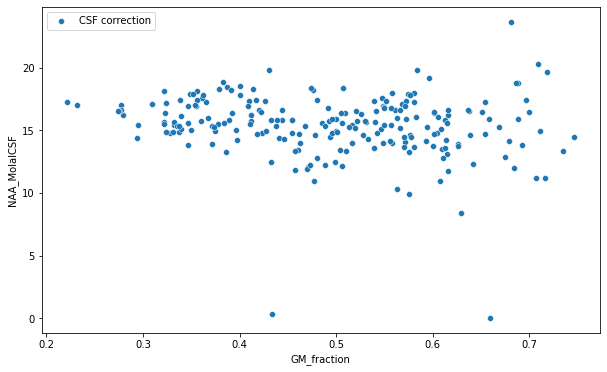

In [20]:
import statsmodels.api as sm

# Assuming all_data is your DataFrame containing the required columns
# Calculate GM_fraction
all_data['GM_fraction'] = all_data['fGM_vol'] / (all_data['fGM_vol'] + all_data['fWM_vol'])

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for NAA_MolalCSF vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='NAA_MolalCSF', label='CSF correction')

# Regression line for NAA_MolalCSF vs GM_fraction
X = sm.add_constant(all_data['GM_fraction'])
model_NAA_MolalCSF = sm.OLS(all_data['NAA_MolalCSF'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='NAA_MolalCSF', scatter=False, label=f'Regression line for CSF correction\nR-squared: {model_NAA_MolalCSF.rsquared:.2f}, p-value: {model_NAA_MolalCSF.pvalues[1]:.4f}\nEquation: y = {model_NAA_MolalCSF.params[0]:.2f} + {model_NAA_MolalCSF.params[1]:.2f}x')

# Scatter plot for NAA_MolalAlpha vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='NAA_MolalAlpha', label='Alpha correction')

# Regression line for NAA_MolalAlpha vs GM_fraction
model_NAA_MolalAlpha = sm.OLS(all_data['NAA_MolalAlpha'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='NAA_MolalAlpha', scatter=False, label=f'Regression line for alpha correction\nR-squared: {model_NAA_MolalAlpha.rsquared:.2f}, p-value: {model_NAA_MolalAlpha.pvalues[1]:.4f}\nEquation: y = {model_NAA_MolalAlpha.params[0]:.2f} + {model_NAA_MolalAlpha.params[1]:.2f}x')

plt.legend()
plt.xlabel('GM fraction')
plt.ylabel('tNAA (mmol/kg)')
plt.title('tNAA')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for Cr_MolalCSF vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='Cr_MolalCSF', label='CSF correction')

# Regression line for Cr_MolalCSF vs GM_fraction
X = sm.add_constant(all_data['GM_fraction'])
model_Cr_MolalCSF = sm.OLS(all_data['Cr_MolalCSF'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='Cr_MolalCSF', scatter=False, label=f'Regression line for CSF correction\nR-squared: {model_Cr_MolalCSF.rsquared:.2f}, p-value: {model_Cr_MolalCSF.pvalues[1]:.4f}\nEquation: y = {model_Cr_MolalCSF.params[0]:.2f} + {model_Cr_MolalCSF.params[1]:.2f}x')

# Scatter plot for Cr_MolalAlpha vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='Cr_MolalAlpha', label='Alpha correction')

# Regression line for Cr_MolalAlpha vs GM_fraction
model_Cr_MolalAlpha = sm.OLS(all_data['Cr_MolalAlpha'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='Cr_MolalAlpha', scatter=False, label=f'Regression line for alpha correction\nR-squared: {model_Cr_MolalAlpha.rsquared:.2f}, p-value: {model_Cr_MolalAlpha.pvalues[1]:.4f}\nEquation: y = {model_Cr_MolalAlpha.params[0]:.2f} + {model_Cr_MolalAlpha.params[1]:.2f}x')

plt.legend()
plt.xlabel('GM fraction')
plt.ylabel('tCr (mmol/kg)')
plt.title('tCr')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for Cho_MolalCSF vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='Cho_MolalCSF', label='CSF correction')

# Regression line for Cho_MolalCSF vs GM_fraction
X = sm.add_constant(all_data['GM_fraction'])
model_Cho_MolalCSF = sm.OLS(all_data['Cho_MolalCSF'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='Cho_MolalCSF', scatter=False, label=f'Regression line for CSF correction\nR-squared: {model_Cho_MolalCSF.rsquared:.2f}, p-value: {model_Cho_MolalCSF.pvalues[1]:.4f}\nEquation: y = {model_Cho_MolalCSF.params[0]:.2f} + {model_Cho_MolalCSF.params[1]:.2f}x')

# Scatter plot for Cho_MolalAlpha vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='Cho_MolalAlpha', label='Alpha correction')

# Regression line for Cho_MolalAlpha vs GM_fraction
model_Cho_MolalAlpha = sm.OLS(all_data['Cho_MolalAlpha'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='Cho_MolalAlpha', scatter=False, label=f'Regression line for alpha correction\nR-squared: {model_Cho_MolalAlpha.rsquared:.2f}, p-value: {model_Cho_MolalAlpha.pvalues[1]:.4f}\nEquation: y = {model_Cho_MolalAlpha.params[0]:.2f} + {model_Cho_MolalAlpha.params[1]:.2f}x')

plt.legend()
plt.xlabel('GM fraction')
plt.ylabel('tCho (mmol/kg)')
plt.title('tCho')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for Myo_MolalCSF vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='Myo_MolalCSF', label='CSF correction')

# Regression line for Myo_MolalCSF vs GM_fraction
X = sm.add_constant(all_data['GM_fraction'])
model_Myo_MolalCSF = sm.OLS(all_data['Myo_MolalCSF'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='Myo_MolalCSF', scatter=False, label=f'Regression line for CSF correction\nR-squared: {model_Myo_MolalCSF.rsquared:.2f}, p-value: {model_Myo_MolalCSF.pvalues[1]:.4f}\nEquation: y = {model_Myo_MolalCSF.params[0]:.2f} + {model_Myo_MolalCSF.params[1]:.2f}x')

# Scatter plot for Myo_MolalAlpha vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='Myo_MolalAlpha', label='Alpha correction')

# Regression line for Myo_MolalAlpha vs GM_fraction
model_Myo_MolalAlpha = sm.OLS(all_data['Myo_MolalAlpha'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='Myo_MolalAlpha', scatter=False, label=f'Regression line for alpha correction\nR-squared: {model_Myo_MolalAlpha.rsquared:.2f}, p-value: {model_Myo_MolalAlpha.pvalues[1]:.4f}\nEquation: y = {model_Myo_MolalAlpha.params[0]:.2f} + {model_Myo_MolalAlpha.params[1]:.2f}x')

plt.legend()
plt.xlabel('GM fraction')
plt.ylabel('Myo (mmol/kg)')
plt.title('Myo')
plt.show()



# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for Glu_MolalCSF vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='Glu_MolalCSF', label='CSF correction')

# Regression line for Glu_MolalCSF vs GM_fraction
X = sm.add_constant(all_data['GM_fraction'])
model_Glu_MolalCSF = sm.OLS(all_data['Glu_MolalCSF'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='Glu_MolalCSF', scatter=False, label=f'Regression line for CSF correction\nR-squared: {model_Glu_MolalCSF.rsquared:.2f}, p-value: {model_Glu_MolalCSF.pvalues[1]:.4f}\nEquation: y = {model_Glu_MolalCSF.params[0]:.2f} + {model_Glu_MolalCSF.params[1]:.2f}x')

# Scatter plot for Glu_MolalAlpha vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='Glu_MolalAlpha', label='Alpha correction')

# Regression line for Glu_MolalAlpha vs GM_fraction
model_Glu_MolalAlpha = sm.OLS(all_data['Glu_MolalAlpha'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='Glu_MolalAlpha', scatter=False, label=f'Regression line for alpha correction\nR-squared: {model_Glu_MolalAlpha.rsquared:.2f}, p-value: {model_Glu_MolalAlpha.pvalues[1]:.4f}\nEquation: y = {model_Glu_MolalAlpha.params[0]:.2f} + {model_Glu_MolalAlpha.params[1]:.2f}x')

plt.legend()
plt.xlabel('GM fraction')
plt.ylabel('Glu (mmol/kg)')
plt.title('Glu')
plt.show()



# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for Glx_MolalCSF vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='Glx_MolalCSF', label='CSF correction')

# Regression line for Glx_MolalCSF vs GM_fraction
X = sm.add_constant(all_data['GM_fraction'])
model_Glx_MolalCSF = sm.OLS(all_data['Glx_MolalCSF'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='Glx_MolalCSF', scatter=False, label=f'Regression line for CSF correction\nR-squared: {model_Glx_MolalCSF.rsquared:.2f}, p-value: {model_Glx_MolalCSF.pvalues[1]:.4f}\nEquation: y = {model_Glx_MolalCSF.params[0]:.2f} + {model_Glx_MolalCSF.params[1]:.2f}x')

# Scatter plot for Glx_MolalAlpha vs GM_fraction
sns.scatterplot(data=all_data, x='GM_fraction', y='Glx_MolalAlpha', label='Alpha correction')

# Regression line for Glx_MolalAlpha vs GM_fraction
model_Glx_MolalAlpha = sm.OLS(all_data['Glx_MolalAlpha'], X).fit()
sns.regplot(data=all_data, x='GM_fraction', y='Glx_MolalAlpha', scatter=False, label=f'Regression line for alpha correction\nR-squared: {model_Glx_MolalAlpha.rsquared:.2f}, p-value: {model_Glx_MolalAlpha.pvalues[1]:.4f}\nEquation: y = {model_Glx_MolalAlpha.params[0]:.2f} + {model_Glx_MolalAlpha.params[1]:.2f}x')

plt.legend()
plt.xlabel('GM fraction')
plt.ylabel('Glx (mmol/kg)')
plt.title('Glx')
plt.show()
